In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import sys
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, sigmoidWarmupAndDecayLRSchedule
# from tools.ae_v6 import Autoencoder
from tools.GRU_SingleStep_v10 import RNN_GRU

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

2023-01-22 00:45:23.497861: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-01-22 00:45:23.498153: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 00:45:23.560447: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 00:45:23.560761: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 00:45:23.561106: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-22 00:45:23.561344: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print('')
print(tf.config.list_logical_devices())
print('')
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # making RNN save directory
    dir_name_rnn = os.getcwd() + dir_sep + 'saved_rnn'
    if not os.path.isdir(dir_name_rnn):
        os.makedirs(dir_name_rnn)

    counter = 0
    while True:
        dir_check = 'rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_rnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_rnn = dir_name_rnn + dir_sep + dir_check
    os.makedirs(dir_name_rnn)
    os.makedirs(dir_name_rnn+dir_sep+'plots')

    # whether to use AE data or just work on raw data
    use_ae_data = False # if false, specifying ae_idx will only show which dataset to use

    # autoencoder directory
    pod_idx = '000'
    dir_name_pod = os.getcwd()+'{ds}saved_pod{ds}pod_'.format(ds=dir_sep)+pod_idx
else:
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_015'

    # reading AE directory
    with open(dir_name_rnn + '/sim_data_POD_params.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))
    
    dir_name_pod = params_dict['dir_name_pod']
    pod_idx = dir_name_pod[-3:]
    dir_name_pod = os.getcwd()+'/saved_pod/pod_'+pod_idx

    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    T_sample_input = params_rnn_dict['T_sample_input']
    T_sample_output = params_rnn_dict['T_sample_output']
    T_offset = params_rnn_dict['T_offset']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in RNN_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
    try:
        dense_layer_act_func = params_rnn_dict['dense_layer_act_func']
    except:
        print("'dense_layer_act_func' not present in RNN_specific_data, set to 'linear'.")
        dense_layer_act_func = 'linear'
    try:
        stateful = params_rnn_dict['stateful']
    except:
        print("'stateful' not present in RNN_specific_data, set to True.")
        stateful = True
    try:
        use_learnable_state = params_rnn_dict['use_learnable_state']
    except:
        print("'use_learnable_state' not present in RNN_specific_data, set to False.")
        use_learnable_state = False
    try:
        use_weights_post_dense = params_rnn_dict['use_weights_post_dense']
    except:
        print("'use_weights_post_dense' not present in RNN_specific_data, set to False.")
        use_weights_post_dense = False


    normalization_arr = None
    try:
        with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
            lines = f.readlines()
        rnn_norm_arr_dict = eval(lines)
        normalization_arr = rnn_norm_arr_dict['normalization_arr']
    except:
        pass
    if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
        with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
            normalization_arr = fl['normalization_arr'][0]

# reading simulation parameters
with open(dir_name_pod + dir_sep + 'pod_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforpod_flag = params_dict['normalizeforpod_flag']
normalization_constant_arr_poddata = params_dict['normalization_constant_arr_poddata']
try:
    pod_data_with_params = params_dict['pod_data_with_params']
except:
    print("'pod_data_with_params' not present in pod_data, set to 'True'.")
    pod_data_with_params = True

if os.path.exists(dir_name_pod+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_pod+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_poddata = fl['normalization_constant_arr_poddata'][0]

print('dir_name_rnn:', dir_name_rnn)
print('dir_name_pod:', dir_name_pod)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data']
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066
dir_name_pod: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_pod/pod_000
data_dir_idx: 005
normalize_flag_ogdata: False


In [13]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [14]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
    ):

    n = len(boundary_idx_arr)
    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, num_yticks)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')

        plt.colorbar(im)
        plt.show()
        print('')

        prev_idx = next_idx

    # '''

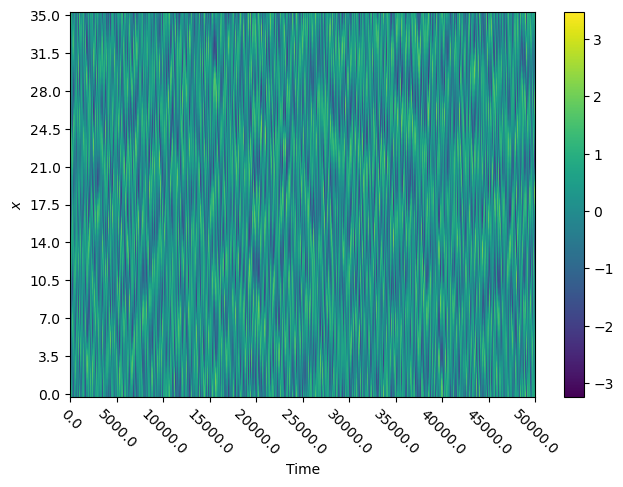

In [15]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

In [16]:
# dealing with normalizing the data before feeding into POD
if pod_data_with_params == False:
    all_data = all_data[:, 0:numpoints_xgrid]
if normalizeforpod_flag == True:
    for i in range(all_data.shape[1]):
        all_data[:, i] -= normalization_constant_arr_poddata[0, i]
        all_data[:, i] /= normalization_constant_arr_poddata[1, i]

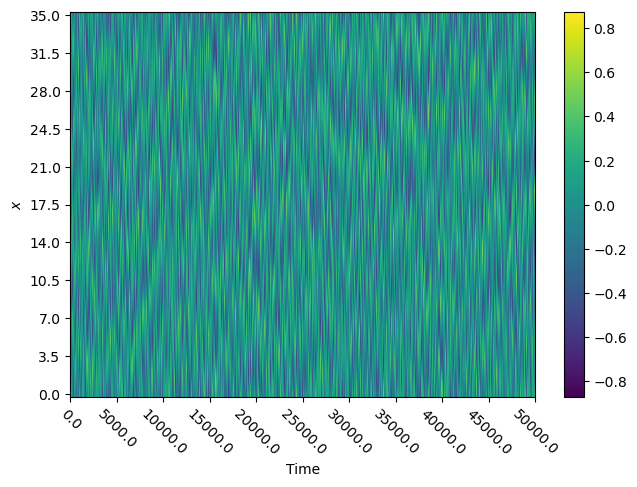

In [17]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=int(40*np.round((T//10)/40))
)

# POD

In [18]:
with np.load(dir_name_pod+'/Wl.npz') as fl:
    Wl = fl['Wl']
    pod_centering_means = fl['pod_centering_means']

In [19]:
latent_states_all = all_data @ Wl

In [20]:
num_latent_states = latent_states_all.shape[1]

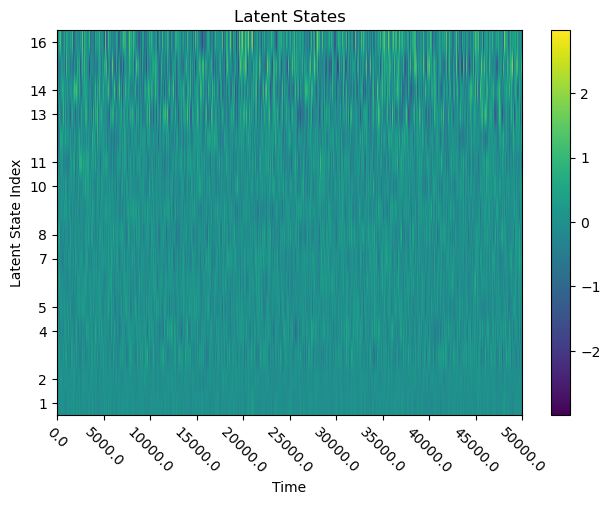

In [21]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_pod,
    xticks_snapto=int(40*np.round((T//10)/40)),
    num_yticks=11,
    save_figs=False)

In [22]:
# for i in range(ae_net.layers):
#     tf.keras.utils.plot_model(
#         ae_net.layers[i],
#         to_file=dir_name_ae+'/plots/netlayer_{}.png'.format(i),
#         show_shapes=True,
#         dpi=300
# )

# GRU

In [24]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = 5 # int(5000/np.mean(lyapunov_time_arr))#
    dt_rnn = 0.2
    T_sample_input = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = dt_rnn
    normalize_dataset = True # whether the data for the RNN should be normalized by the dataset's mean and std
    normalization_arr = None
    skip_intermediate = 'full sample'
    noise_type = 'normal' # can be 'uniform' or 'normal'

    # can be 'minmax', 'minmax2', 'stddev', or a list with
    # sequential order of any of these; if it is 'minmax'
    # then stddev_multiplier has no effect
    normalization_type = 'stddev'
    stddev_multiplier = 3

    dense_layer_act_func = ['tanh']
    use_weights_post_dense = True
    stateful = True
    use_learnable_state = False
    use_trainable_weights_with_reslayers = True
        
    if return_params_arr != False:
        params = params_arr
    else:
        params = None
        
    # timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)

    # saving simulation data
    sim_data = {
        'params_mat':params_mat,
        'init_state_mat':init_state_mat,
        't0':t0,
        'T':T,
        'delta_t':delta_t,
        'return_params_arr':return_params_arr,
        'dir_name_pod':dir_name_pod,
        'normalize_dataset':normalize_dataset,
        'stddev_multiplier':stddev_multiplier,
    }


    with open(dir_name_rnn+dir_sep+'sim_data_AE_params.txt', 'w') as f:
        f.write(str(sim_data))
        
    # saving RNN specific data
    RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':RNN_GRU.__module__,
        'noise_type':noise_type,
        'normalization_type':normalization_type,
        'dense_layer_act_func':dense_layer_act_func,
        'stateful':stateful,
        'use_learnable_state':use_learnable_state,
        'use_weights_post_dense':use_weights_post_dense,
        'use_trainable_weights_with_reslayers':use_trainable_weights_with_reslayers,
    }

    with open(dir_name_rnn+dir_sep+'RNN_specific_data.txt', 'w') as f:
        f.write(str(RNN_specific_data))

In [25]:
rnn_res_dict = create_data_for_RNN(
    latent_states_all,
    dt_rnn,
    T_sample_input,
    T_sample_output,
    T_offset,
    None,
    boundary_idx_arr,
    delta_t,
    params=params,
    return_numsamples=True,
    normalize_dataset=normalize_dataset,
    stddev_multiplier=stddev_multiplier,
    skip_intermediate=skip_intermediate,
    return_OrgDataIdxArr=False,
    normalization_arr_external=normalization_arr,
    normalization_type=normalization_type)
    
data_rnn_input = rnn_res_dict['data_rnn_input']
data_rnn_output = rnn_res_dict['data_rnn_output']
org_data_idx_arr_input = rnn_res_dict['org_data_idx_arr_input']
org_data_idx_arr_output = rnn_res_dict['org_data_idx_arr_output']
num_samples = rnn_res_dict['num_samples']
normalization_arr = rnn_res_dict['normalization_arr']
rnn_data_boundary_idx_arr = rnn_res_dict['rnn_data_boundary_idx_arr']

In [26]:
temp = np.divide(latent_states_all-normalization_arr[0], normalization_arr[1])
time_stddev = np.std(temp, axis=0)
timeMeanofSpaceRMS = np.mean(np.mean(temp**2, axis=1)**0.5)
del(org_data_idx_arr_input)
del(org_data_idx_arr_output)
del(latent_states_all)
del(temp)

In [27]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [1e-3, 1e-4, 1e-5]
    epochs = 1000
    patience = 10 # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 5e-7  # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 64
    fRMS = 2/100
    zoneout_rate = 0.0
    rnncell_dropout_rate = 0.0
    denselayer_dropout_rate = 0.0
    

    stddev = fRMS*timeMeanofSpaceRMS
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
        'stddev':stddev,
        'zoneout_rate':zoneout_rate,
        'rnncell_dropout_rate':rnncell_dropout_rate,
        'denselayer_dropout_rate':denselayer_dropout_rate,
    }

    with open(dir_name_rnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_rnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr],
    )
    
else:
    # dir_name_rnn_og = dir_name_rnn
    # dir_name_rnn_temp = '/home/rkaushik/Documents/Thesis/MLROM/CDV/saved_rnn/rnn_'+dir_name_rnn_og[-3:]
    # dir_name_rnn = dir_name_rnn_temp

    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()


    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [28]:
# idx = np.arange(data_rnn_input.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round(train_split*data_rnn_input.shape[0]))

# training_data_rnn_input = data_rnn_input[idx[0:boundary]]
# training_data_rnn_output = data_rnn_output[idx[0:boundary]]

# testing_data_rnn_input = data_rnn_input[idx[boundary:]]
# testing_data_rnn_output = data_rnn_output[idx[boundary:]]

In [29]:
cum_samples = rnn_data_boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_val_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_test_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
num_samples_arr = np.zeros(shape=rnn_data_boundary_idx_arr.shape[0], dtype='int32')
begin_idx = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    num_samples = rnn_data_boundary_idx_arr[i] - begin_idx
    num_train_arr[i] = batch_size * (int( (1-test_split-val_split)*num_samples )//batch_size)
    num_val_arr[i] = batch_size * (int(val_split*num_samples)//batch_size)
    num_test_arr[i] = batch_size * int((num_samples - num_train_arr[i] - num_val_arr[i])//batch_size)
    num_samples_arr[i] = num_train_arr[i] + num_val_arr[i] + num_test_arr[i]
    begin_idx = rnn_data_boundary_idx_arr[i]

# defining shapes
training_input_shape = [np.sum(num_train_arr)]
training_input_shape.extend(data_rnn_input.shape[1:])

training_output_shape = [np.sum(num_train_arr)]
training_output_shape.extend(data_rnn_output.shape[1:])

val_input_shape = [np.sum(num_val_arr)]
val_input_shape.extend(data_rnn_input.shape[1:])

val_output_shape = [np.sum(num_val_arr)]
val_output_shape.extend(data_rnn_output.shape[1:])

testing_input_shape = [np.sum(num_test_arr)]
testing_input_shape.extend(data_rnn_input.shape[1:])

testing_output_shape = [np.sum(num_test_arr)]
testing_output_shape.extend(data_rnn_output.shape[1:])

# defining required arrays
training_data_rnn_input = np.empty(shape=training_input_shape)
training_data_rnn_output = np.empty(shape=training_output_shape)

val_data_rnn_input = np.empty(shape=val_input_shape)
val_data_rnn_output = np.empty(shape=val_output_shape)

testing_data_rnn_input = np.empty(shape=testing_input_shape)
testing_data_rnn_output = np.empty(shape=testing_output_shape)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    # num_samples = idx.shape[0]
    # num_train = int( (1-test_split-val_split)*num_samples )
    # num_val = int(val_split*num_samples)
    num_samples = num_samples_arr[i]
    num_train = num_train_arr[i]
    num_val = num_val_arr[i]
    num_test = num_test_arr[i]
    
    nbatches_train = num_train // batch_size
    nbatches_val = num_val // batch_size
    nbatches_test = num_test // batch_size

    for j in range(batch_size):
        training_data_rnn_input[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_input[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        training_data_rnn_output[training_data_rolling_count+j:training_data_rolling_count+num_train:batch_size] = data_rnn_output[idx[0:num_train]][j*nbatches_train:(j+1)*nbatches_train]
        
        val_data_rnn_input[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_input[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]
        val_data_rnn_output[val_data_rolling_count+j:val_data_rolling_count+num_val:batch_size] = data_rnn_output[idx[num_train:num_train+num_val]][j*nbatches_val:(j+1)*nbatches_val]

        testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_input[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]
        testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size] = data_rnn_output[idx[num_train+num_val:num_samples]][j*nbatches_test:(j+1)*nbatches_test]


    # training_data_rnn_input[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_input[idx[0:num_train]]
    # training_data_rnn_output[training_data_rolling_count:training_data_rolling_count+num_train] = data_rnn_output[idx[0:num_train]]
    training_data_rolling_count += num_train

    # val_data_rnn_input[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_input[idx[num_train:num_train+num_val]]
    # val_data_rnn_output[val_data_rolling_count:val_data_rolling_count+num_val] = data_rnn_output[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    # num_test = num_samples-num_train-num_val+1
    # testing_data_rnn_input[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_input[idx[num_train+num_val:]]
    # testing_data_rnn_output[testing_data_rolling_count:testing_data_rolling_count+num_test] = data_rnn_output[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

# cleaning up
del(data_rnn_input)
del(data_rnn_output)

# further shuffling
if stateful == False:
    idx = np.arange(0, training_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    training_data_rnn_input = training_data_rnn_input[idx]
    training_data_rnn_output = training_data_rnn_output[idx]

    idx = np.arange(0, val_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    val_data_rnn_input = val_data_rnn_input[idx]
    val_data_rnn_output = val_data_rnn_output[idx]

    idx = np.arange(0, testing_data_rnn_input.shape[0])
    np.random.shuffle(idx)
    testing_data_rnn_input = testing_data_rnn_input[idx]
    testing_data_rnn_output = testing_data_rnn_output[idx]

    del(idx)

In [30]:
print('training_data_rnn_input.shape : ', training_data_rnn_input.shape)
print(' testing_data_rnn_input.shape : ', testing_data_rnn_input.shape)
print('     val_data_rnn_input.shape : ', val_data_rnn_input.shape)

training_data_rnn_input.shape :  (512, 387, 16)
 testing_data_rnn_input.shape :  (64, 387, 16)
     val_data_rnn_input.shape :  (64, 387, 16)


In [31]:
# print(rnn_data_boundary_idx_arr)

In [32]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    rnn_layers_units = [500]*3
    scalar_weights = None
    # scalar_weights = [
    #     0.5, 
    #     0.0, 0.5,
    #     0.0, 0.0, 1.0,
    #     1/6, 1/3, 1/3, 1/6
    # ] # RK4
    # scalar_weights = [
    #     1.0,
    #     0.25, 0.25,
    #     1/6, 1/6, 2/3
    # ] # TVD RK3
    # scalar_weights = [
    #     1.0,
    #     0.5, 0.5
    # ] # TVD RK2
    # rnn_layers_units = [500]*int(1 + ( (8*len(scalar_weights)+1)**0.5 - 1 )/2)
    # timeMeanofSpaceRMS = np.mean(np.mean(latent_states_all**2, axis=1)**0.5)
    print('timeMeanofSpaceRMS :', timeMeanofSpaceRMS)
    print('stddev :', stddev)
    if return_params_arr != False:
        data_dim = num_latent_states + 3
    else:
        data_dim = num_latent_states

    dense_dim = [rnn_layers_units[-1]]*(len(dense_layer_act_func)-1)
    dense_dim.append(data_dim)
        
    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN_GRU(
                data_dim=data_dim,
            #     in_steps=int(T_sample_input // dt_rnn),
            #     out_steps=int(T_sample_output // dt_rnn),
                dt_rnn=dt_rnn,
                lambda_reg=lambda_reg,
                reg_name='L2',
                rnn_layers_units=rnn_layers_units,
                dense_layer_act_func=dense_layer_act_func,
                load_file=None,
                # T_input=T_sample_input,
                # T_output=T_sample_output,
                stddev=stddev,
                noise_type=noise_type,
                dense_dim=dense_dim,
                use_learnable_state=use_learnable_state,
                stateful=stateful,
                zoneout_rate=zoneout_rate,
                batch_size=batch_size,
                use_weights_post_dense=use_weights_post_dense,
                rnncell_dropout_rate=rnncell_dropout_rate,
                denselayer_dropout_rate=denselayer_dropout_rate,
                scalar_weights=scalar_weights, # corresponding to RK4
                use_trainable_weights_with_reslayers=use_trainable_weights_with_reslayers,
            )
    else:
        rnn_net = RNN_GRU(
            data_dim=data_dim,
        #     in_steps=int(T_sample_input // dt_rnn),
        #     out_steps=int(T_sample_output // dt_rnn),
            dt_rnn=dt_rnn,
            lambda_reg=lambda_reg,
            reg_name='L2',
            rnn_layers_units=rnn_layers_units,
            dense_layer_act_func=dense_layer_act_func,
            load_file=None,
            # T_input=T_sample_input,
            # T_output=T_sample_output,
            stddev=stddev,
            noise_type=noise_type,
            dense_dim=dense_dim,
            use_learnable_state=use_learnable_state,
            stateful=stateful,
            zoneout_rate=zoneout_rate,
            batch_size=batch_size,
            use_weights_post_dense=use_weights_post_dense,
            rnncell_dropout_rate=rnncell_dropout_rate,
            denselayer_dropout_rate=denselayer_dropout_rate,
            scalar_weights=scalar_weights, # corresponding to RK4
            use_trainable_weights_with_reslayers=use_trainable_weights_with_reslayers,
        )
    save_path = dir_name_rnn+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    rnn_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_rnn + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    if strategy is not None:
        with strategy.scope():
            rnn_net = RNN_GRU(
                load_file=load_file,
                # T_input=T_sample_input,
                # T_output=T_sample_output,
                batch_size=batch_size,
                
            )
    else:
        rnn_net = RNN_GRU(
            load_file=load_file,
            # T_input=T_sample_input,
            # T_output=T_sample_output,
            batch_size=batch_size
        )

    rnn_net.build(input_shape=(batch_size, None, num_latent_states))
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_rnn+dir_sep+'checkpoints')
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'final_net_gru_weights.h5'
        # wt_file = dir_name_rnn+dir_sep+'final_net'+dir_sep+'f2'#+dir_sep+'saved_model.pb'
        rnn_net.load_weights_from_file(wt_file)
    
    # this forces the model to initialize its kernel weights/biases
    # temp = rnn_net.predict(tf.ones(shape=[batch_size, int(T_sample_input//dt_rnn), rnn_net.data_dim]))
    # this loads just the kernel wieghts and biases of the model
#     rnn_net.load_weights_from_file(wt_file)

    # rnn_net = tf.keras.models.load_model(wt_file)

timeMeanofSpaceRMS : 0.36533452237364467
stddev : 0.007306690447472893


In [33]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
    earlystopping_wait = 0
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt, earlystopping_wait = readAndReturnLossHistories(
        dir_name_ae=dir_name_rnn,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=learning_rate_list,
        return_earlystopping_wait=True)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_rnn+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [34]:
train_NMSE_hist = []
val_NMSE_hist = []

train_MSE_hist = []
val_MSE_hist = []

In [35]:
class NMSE(tf.keras.metrics.MeanSquaredError):
    def __init__(self, divisor_arr, name='NMSE', **kwargs):
        super(NMSE, self).__init__(name, **kwargs)
        self.divisor_arr = divisor_arr

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = y_true / self.divisor_arr
        y_pred = y_pred / self.divisor_arr
        return super(NMSE, self).update_state(y_true, y_pred, sample_weight)

In [36]:
# compiling the network
rnn_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
    metrics=['mse', NMSE(divisor_arr=time_stddev)],
    run_eagerly=False
)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    if strategy is not None:
        with strategy.scope():
            rnn_net.load_weights(wt_file)
    else:
        rnn_net.load_weights(wt_file)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    baseline = None
    if behaviour == 'loadCheckpointAndContinueTraining':
        baseline = np.min(val_loss_hist)
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_NMSE',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta,
        baseline=baseline
    )
    #** the two lines below are useless because wait is set to 0 in on_train_begin
    # early_stopping_cb.wait = earlystopping_wait
    # print('early_stopping_cb.wait : {}\n'.format(early_stopping_cb.wait))

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_rnn+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_NMSE',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        initial_value_threshold=baseline,
        period=1  # saves every `period` epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=1)

    for i in range(starting_lr_idx, len(learning_rate_list)):
        learning_rate = learning_rate_list[i]
        K.set_value(rnn_net.optimizer.lr, learning_rate)

        savelosses_cb.update_lr_idx(i)

        if i == starting_lr_idx:
            EPOCHS = num_epochs_left
            savelosses_cb.update_offset(epochs-num_epochs_left)
        else:
            EPOCHS = epochs
            savelosses_cb.update_offset(0)

        total_s_len = 80
        sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')
        
        history = rnn_net.fit(training_data_rnn_input, training_data_rnn_output,
            epochs=EPOCHS,
            batch_size=batch_size,
#             validation_split=val_split/train_split,
            validation_data=(val_data_rnn_input, val_data_rnn_output),
            callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
            verbose=1,
            shuffle=not stateful,
        )

        val_loss_hist.extend(history.history['val_loss'])
        train_loss_hist.extend(history.history['loss'])
        
        val_NMSE_hist.extend(history.history['val_NMSE'])
        train_NMSE_hist.extend(history.history['NMSE'])

        val_MSE_hist.extend(history.history['val_mse'])
        train_MSE_hist.extend(history.history['mse'])
        
        if i == starting_lr_idx:
            lr_change[i+1] += len(history.history['val_loss'])
        else:
            lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
8/8 [==============================] - ETA: 0s - loss: 0.0423 - mse: 0.0415 - NMSE: 0.4256 - tot_time: 0h 0m 18.7s

Epoch 1: val_NMSE improved from inf to 0.17423, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 19s 2s/step - loss: 0.0423 - mse: 0.0415 - NMSE: 0.4256 - val_loss: 0.0157 - val_mse: 0.0149 - val_NMSE: 0.1742
Epoch 2/1000
8/8 [==============================] - ETA: 0s - loss: 0.0112 - mse: 0.0104 - NMSE: 0.1087 - tot_time: 0h 0m 33.4s

Epoch 2: val_NMSE improved from 0.17423 to 0.07128, saving model to /home

8/8 [==============================] - ETA: 0s - loss: 0.0029 - mse: 0.0023 - NMSE: 0.0131 - tot_time: 0h 3m 46.0s

Epoch 15: val_NMSE improved from 0.01595 to 0.01521, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 0.0029 - mse: 0.0023 - NMSE: 0.0131 - val_loss: 0.0034 - val_mse: 0.0027 - val_NMSE: 0.0152
Epoch 16/1000
8/8 [==============================] - ETA: 0s - loss: 0.0028 - mse: 0.0022 - NMSE: 0.0125 - tot_time: 0h 4m 0.6s

Epoch 16: val_NMSE improved from 0.01521 to 0.01455, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - los

Epoch 30/1000
8/8 [==============================] - ETA: 0s - loss: 0.0020 - mse: 0.0016 - NMSE: 0.0079 - tot_time: 0h 7m 27.1s

Epoch 30: val_NMSE improved from 0.01001 to 0.00984, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 0.0020 - mse: 0.0016 - NMSE: 0.0079 - val_loss: 0.0024 - val_mse: 0.0020 - val_NMSE: 0.0098
Epoch 31/1000
8/8 [==============================] - ETA: 0s - loss: 0.0020 - mse: 0.0016 - NMSE: 0.0077 - tot_time: 0h 7m 41.9s

Epoch 31: val_NMSE improved from 0.00984 to 0.00970, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15

Epoch 45/1000
8/8 [==============================] - ETA: 0s - loss: 0.0016 - mse: 0.0012 - NMSE: 0.0064 - tot_time: 0h 11m 9.2s

Epoch 45: val_NMSE improved from 0.00804 to 0.00793, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 0.0016 - mse: 0.0012 - NMSE: 0.0064 - val_loss: 0.0018 - val_mse: 0.0015 - val_NMSE: 0.0079
Epoch 46/1000
8/8 [==============================] - ETA: 0s - loss: 0.0015 - mse: 0.0012 - NMSE: 0.0063 - tot_time: 0h 11m 24.0s

Epoch 46: val_NMSE improved from 0.00793 to 0.00783, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 1

Epoch 60/1000
8/8 [==============================] - ETA: 0s - loss: 0.0013 - mse: 9.3735e-04 - NMSE: 0.0054 - tot_time: 0h 14m 51.5s

Epoch 60: val_NMSE improved from 0.00688 to 0.00687, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 0.0013 - mse: 9.3735e-04 - NMSE: 0.0054 - val_loss: 0.0015 - val_mse: 0.0012 - val_NMSE: 0.0069
Epoch 61/1000
8/8 [==============================] - ETA: 0s - loss: 0.0012 - mse: 9.1982e-04 - NMSE: 0.0054 - tot_time: 0h 15m 6.3s

Epoch 61: val_NMSE did not improve from 0.00687
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 0.0012 - mse: 9.1982e-04 - NMSE: 0.0054 - val_loss: 0.0015 - val_mse: 0.

8/8 [==============================] - ETA: 0s - loss: 9.6528e-04 - mse: 6.6484e-04 - NMSE: 0.0047 - tot_time: 0h 18m 45.6s

Epoch 76: val_NMSE improved from 0.00604 to 0.00595, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 9.6528e-04 - mse: 6.6484e-04 - NMSE: 0.0047 - val_loss: 0.0012 - val_mse: 8.5393e-04 - val_NMSE: 0.0060
Epoch 77/1000
8/8 [==============================] - ETA: 0s - loss: 9.4954e-04 - mse: 6.4984e-04 - NMSE: 0.0046 - tot_time: 0h 19m 0.5s

Epoch 77: val_NMSE did not improve from 0.00595
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 9.4954e-04 - mse: 6.4984e-04 - NMSE: 0.0046 - val_loss: 0.0011 - val_m

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 7.9210e-04 - mse: 5.0185e-04 - NMSE: 0.0040 - val_loss: 9.6987e-04 - val_mse: 6.7994e-04 - val_NMSE: 0.0051
Epoch 92/1000
8/8 [==============================] - ETA: 0s - loss: 7.7981e-04 - mse: 4.9014e-04 - NMSE: 0.0038 - tot_time: 0h 22m 40.1s

Epoch 92: val_NMSE did not improve from 0.00506
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 7.7981e-04 - mse: 4.9014e-04 - NMSE: 0.0038 - val_loss: 9.6403e-04 - val_mse: 6.7469e-04 - val_NMSE: 0.0051
Epoch 93/1000
8/8 [==============================] - ETA: 0s - loss: 7.7236e-04 - mse: 4.8328e-04 - NMSE: 0.0038 - tot_time: 0h 22m 54.5s

Epoch 93: val_NMSE did not improve from 0.00506
 - saving loss histories at /home/rkaushik/Doc

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 6.8932e-04 - mse: 4.0778e-04 - NMSE: 0.0033 - val_loss: 8.7310e-04 - val_mse: 5.9190e-04 - val_NMSE: 0.0045
Epoch 107/1000
8/8 [==============================] - ETA: 0s - loss: 6.8857e-04 - mse: 4.0761e-04 - NMSE: 0.0033 - tot_time: 0h 26m 20.7s

Epoch 107: val_NMSE improved from 0.00453 to 0.00450, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 6.8857e-04 - mse: 4.0761e-04 - NMSE: 0.0033 - val_loss: 8.7031e-04 - val_mse: 5.8969e-04 - val_NMSE: 0.0045
Epoch 108/1000
8/8 [==============================] - ETA: 0s - loss: 6.8790e-04 - mse: 4.0752e-04 - NMSE: 0.0033 - tot_time: 0h

Epoch 122/1000
8/8 [==============================] - ETA: 0s - loss: 6.3312e-04 - mse: 3.6071e-04 - NMSE: 0.0031 - tot_time: 0h 30m 1.9s

Epoch 122: val_NMSE did not improve from 0.00430
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 6.3312e-04 - mse: 3.6071e-04 - NMSE: 0.0031 - val_loss: 8.0610e-04 - val_mse: 5.3401e-04 - val_NMSE: 0.0044
Epoch 123/1000
8/8 [==============================] - ETA: 0s - loss: 6.3652e-04 - mse: 3.6467e-04 - NMSE: 0.0031 - tot_time: 0h 30m 16.6s

Epoch 123: val_NMSE did not improve from 0.00430
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 6.3652e-04 - mse: 3.6467e-04 - NMSE: 0.0031 - val_loss: 8.1275e-04 - val_mse: 5.4122e-04 - val_NMSE: 0.0044
Epoch 124/1000
8/8 [=======================

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 5.8591e-04 - mse: 3.2179e-04 - NMSE: 0.0029 - val_loss: 7.4663e-04 - val_mse: 4.8283e-04 - val_NMSE: 0.0040
Epoch 138/1000
8/8 [==============================] - ETA: 0s - loss: 5.8722e-04 - mse: 3.2365e-04 - NMSE: 0.0029 - tot_time: 0h 34m 0.3s

Epoch 138: val_NMSE did not improve from 0.00404
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 5.8722e-04 - mse: 3.2365e-04 - NMSE: 0.0029 - val_loss: 7.6448e-04 - val_mse: 5.0123e-04 - val_NMSE: 0.0041
Epoch 139/1000
8/8 [==============================] - ETA: 0s - loss: 6.0784e-04 - mse: 3.4482e-04 - NMSE: 0.0030 - tot_time: 0h 34m 14.9s

Epoch 139: val_NMSE did not improve from 0.00404
 - saving loss histories at /home/rkaushik/

8/8 [==============================] - ETA: 0s - loss: 5.4576e-04 - mse: 2.9018e-04 - NMSE: 0.0029 - tot_time: 0h 37m 40.0s

Epoch 153: val_NMSE did not improve from 0.00385
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 5.4576e-04 - mse: 2.9018e-04 - NMSE: 0.0029 - val_loss: 6.9145e-04 - val_mse: 4.3616e-04 - val_NMSE: 0.0039
Epoch 154/1000
8/8 [==============================] - ETA: 0s - loss: 5.4320e-04 - mse: 2.8813e-04 - NMSE: 0.0028 - tot_time: 0h 37m 54.6s

Epoch 154: val_NMSE improved from 0.00385 to 0.00380, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 5.4320e-04 - mse: 2.8813e-04 - NMSE: 0.0028 - val_loss: 6.8557

Epoch 169/1000
8/8 [==============================] - ETA: 0s - loss: 4.6399e-04 - mse: 2.1648e-04 - NMSE: 0.0024 - tot_time: 0h 41m 36.1s

Epoch 169: val_NMSE did not improve from 0.00343
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 4.6399e-04 - mse: 2.1648e-04 - NMSE: 0.0024 - val_loss: 5.9867e-04 - val_mse: 3.5144e-04 - val_NMSE: 0.0035
Epoch 170/1000
8/8 [==============================] - ETA: 0s - loss: 4.6314e-04 - mse: 2.1613e-04 - NMSE: 0.0024 - tot_time: 0h 41m 50.6s

Epoch 170: val_NMSE did not improve from 0.00343
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 4.6314e-04 - mse: 2.1613e-04 - NMSE: 0.0024 - val_loss: 6.0070e-04 - val_mse: 3.5398e-04 - val_NMSE: 0.0035
Epoch 171/1000
8/8 [======================

8/8 [==============================] - ETA: 0s - loss: 4.2340e-04 - mse: 1.8369e-04 - NMSE: 0.0021 - tot_time: 0h 45m 18.5s

Epoch 184: val_NMSE did not improve from 0.00309
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 4.2340e-04 - mse: 1.8369e-04 - NMSE: 0.0021 - val_loss: 5.4665e-04 - val_mse: 3.0724e-04 - val_NMSE: 0.0031
Epoch 185/1000
8/8 [==============================] - ETA: 0s - loss: 4.2021e-04 - mse: 1.8103e-04 - NMSE: 0.0021 - tot_time: 0h 45m 32.9s

Epoch 185: val_NMSE improved from 0.00309 to 0.00305, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 4.2021e-04 - mse: 1.8103e-04 - NMSE: 0.0021 - val_loss: 5.4063

Epoch 200/1000
8/8 [==============================] - ETA: 0s - loss: 3.9620e-04 - mse: 1.6522e-04 - NMSE: 0.0020 - tot_time: 0h 49m 13.2s

Epoch 200: val_NMSE did not improve from 0.00297
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 3.9620e-04 - mse: 1.6522e-04 - NMSE: 0.0020 - val_loss: 5.1234e-04 - val_mse: 2.8168e-04 - val_NMSE: 0.0030
Epoch 201/1000
8/8 [==============================] - ETA: 0s - loss: 3.9346e-04 - mse: 1.6303e-04 - NMSE: 0.0020 - tot_time: 0h 49m 27.8s

Epoch 201: val_NMSE improved from 0.00297 to 0.00293, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.9346e-04 - mse: 1.6303e-04 - NMSE: 0.0020 - v

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.6955e-04 - mse: 1.4061e-04 - NMSE: 0.0017 - val_loss: 4.8414e-04 - val_mse: 2.5523e-04 - val_NMSE: 0.0027
Epoch 3/1000
8/8 [==============================] - ETA: 0s - loss: 3.6702e-04 - mse: 1.3814e-04 - NMSE: 0.0017 - tot_time: 0h 53m 8.8s

Epoch 3: val_NMSE improved from 0.00266 to 0.00263, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.6702e-04 - mse: 1.3814e-04 - NMSE: 0.0017 - val_loss: 4.8119e-04 - val_mse: 2.5235e-04 - val_NMSE: 0.0026
Epoch 4/1000
8/8 [==============================] - ETA: 0s - loss: 3.6596e-04 - mse: 1.3714e-04 - NMSE: 0.0017 - tot_time: 0h 53m 23

8/8 [==============================] - ETA: 0s - loss: 3.6327e-04 - mse: 1.3521e-04 - NMSE: 0.0016 - tot_time: 0h 56m 39.5s

Epoch 17: val_NMSE improved from 0.00261 to 0.00260, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.6327e-04 - mse: 1.3521e-04 - NMSE: 0.0016 - val_loss: 4.7781e-04 - val_mse: 2.4979e-04 - val_NMSE: 0.0026
Epoch 18/1000
8/8 [==============================] - ETA: 0s - loss: 3.6300e-04 - mse: 1.3501e-04 - NMSE: 0.0016 - tot_time: 0h 56m 54.4s

Epoch 18: val_NMSE did not improve from 0.00260
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.6300e-04 - mse: 1.3501e-04 - NMSE: 0.0016 - val_loss: 4.7791e-0

Epoch 33/1000
8/8 [==============================] - ETA: 0s - loss: 3.6058e-04 - mse: 1.3354e-04 - NMSE: 0.0016 - tot_time: 1h 0m 36.1s

Epoch 33: val_NMSE improved from 0.00259 to 0.00259, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.6058e-04 - mse: 1.3354e-04 - NMSE: 0.0016 - val_loss: 4.7482e-04 - val_mse: 2.4782e-04 - val_NMSE: 0.0026
Epoch 34/1000
8/8 [==============================] - ETA: 0s - loss: 3.6058e-04 - mse: 1.3360e-04 - NMSE: 0.0016 - tot_time: 1h 0m 50.9s

Epoch 34: val_NMSE improved from 0.00259 to 0.00259, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [====

Epoch 49/1000
8/8 [==============================] - ETA: 0s - loss: 3.5813e-04 - mse: 1.3217e-04 - NMSE: 0.0016 - tot_time: 1h 4m 32.4s

Epoch 49: val_NMSE improved from 0.00258 to 0.00258, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 16s 2s/step - loss: 3.5813e-04 - mse: 1.3217e-04 - NMSE: 0.0016 - val_loss: 4.7157e-04 - val_mse: 2.4565e-04 - val_NMSE: 0.0026
Epoch 50/1000
8/8 [==============================] - ETA: 0s - loss: 3.5799e-04 - mse: 1.3210e-04 - NMSE: 0.0016 - tot_time: 1h 4m 48.8s

Epoch 50: val_NMSE improved from 0.00258 to 0.00258, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [====

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.5541e-04 - mse: 1.3053e-04 - NMSE: 0.0016 - val_loss: 4.6826e-04 - val_mse: 2.4341e-04 - val_NMSE: 0.0026
Epoch 65/1000
8/8 [==============================] - ETA: 0s - loss: 3.5540e-04 - mse: 1.3058e-04 - NMSE: 0.0016 - tot_time: 1h 8m 31.4s

Epoch 65: val_NMSE improved from 0.00257 to 0.00256, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.5540e-04 - mse: 1.3058e-04 - NMSE: 0.0016 - val_loss: 4.6785e-04 - val_mse: 2.4307e-04 - val_NMSE: 0.0026
Epoch 66/1000
8/8 [==============================] - ETA: 0s - loss: 3.5526e-04 - mse: 1.3053e-04 - NMSE: 0.0016 - tot_time: 1h 8m 

8/8 [==============================] - ETA: 0s - loss: 3.5283e-04 - mse: 1.2916e-04 - NMSE: 0.0016 - tot_time: 1h 12m 12.5s

Epoch 80: val_NMSE improved from 0.00256 to 0.00255, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.5283e-04 - mse: 1.2916e-04 - NMSE: 0.0016 - val_loss: 4.6450e-04 - val_mse: 2.4087e-04 - val_NMSE: 0.0026
Epoch 81/1000
8/8 [==============================] - ETA: 0s - loss: 3.5280e-04 - mse: 1.2920e-04 - NMSE: 0.0016 - tot_time: 1h 12m 27.5s

Epoch 81: val_NMSE did not improve from 0.00255
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.5280e-04 - mse: 1.2920e-04 - NMSE: 0.0016 - val_loss: 4.6455e-0

8/8 [==============================] - ETA: 0s - loss: 3.5004e-04 - mse: 1.2765e-04 - NMSE: 0.0016 - tot_time: 1h 16m 6.7s

Epoch 96: val_NMSE did not improve from 0.00255
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.5004e-04 - mse: 1.2765e-04 - NMSE: 0.0016 - val_loss: 4.6135e-04 - val_mse: 2.3901e-04 - val_NMSE: 0.0025
Epoch 97/1000
8/8 [==============================] - ETA: 0s - loss: 3.5001e-04 - mse: 1.2770e-04 - NMSE: 0.0016 - tot_time: 1h 16m 21.1s

Epoch 97: val_NMSE improved from 0.00255 to 0.00254, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 16s 2s/step - loss: 3.5001e-04 - mse: 1.2770e-04 - NMSE: 0.0016 - val_loss: 4.6077e-04

Epoch 112/1000
8/8 [==============================] - ETA: 0s - loss: 3.4747e-04 - mse: 1.2643e-04 - NMSE: 0.0016 - tot_time: 1h 20m 2.1s

Epoch 112: val_NMSE did not improve from 0.00253
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 3.4747e-04 - mse: 1.2643e-04 - NMSE: 0.0016 - val_loss: 4.5743e-04 - val_mse: 2.3644e-04 - val_NMSE: 0.0025
Epoch 113/1000
8/8 [==============================] - ETA: 0s - loss: 3.4736e-04 - mse: 1.2641e-04 - NMSE: 0.0016 - tot_time: 1h 20m 16.4s

Epoch 113: val_NMSE did not improve from 0.00253
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 3.4736e-04 - mse: 1.2641e-04 - NMSE: 0.0016 - val_loss: 4.5732e-04 - val_mse: 2.3642e-04 - val_NMSE: 0.0025
Epoch 114/1000
8/8 [=======================

Epoch 128/1000
8/8 [==============================] - ETA: 0s - loss: 3.4468e-04 - mse: 1.2506e-04 - NMSE: 0.0016 - tot_time: 1h 23m 57.4s

Epoch 128: val_NMSE did not improve from 0.00252
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.4468e-04 - mse: 1.2506e-04 - NMSE: 0.0016 - val_loss: 4.5385e-04 - val_mse: 2.3428e-04 - val_NMSE: 0.0025
Epoch 129/1000
8/8 [==============================] - ETA: 0s - loss: 3.4436e-04 - mse: 1.2484e-04 - NMSE: 0.0016 - tot_time: 1h 24m 11.9s

Epoch 129: val_NMSE did not improve from 0.00252
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 3.4436e-04 - mse: 1.2484e-04 - NMSE: 0.0016 - val_loss: 4.5345e-04 - val_mse: 2.3397e-04 - val_NMSE: 0.0025
Epoch 130/1000
8/8 [======================

Epoch 144/1000
8/8 [==============================] - ETA: 0s - loss: 3.4137e-04 - mse: 1.2325e-04 - NMSE: 0.0016 - tot_time: 1h 27m 52.7s

Epoch 144: val_NMSE did not improve from 0.00251
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.4137e-04 - mse: 1.2325e-04 - NMSE: 0.0016 - val_loss: 4.4988e-04 - val_mse: 2.3181e-04 - val_NMSE: 0.0025
Epoch 145/1000
8/8 [==============================] - ETA: 0s - loss: 3.4128e-04 - mse: 1.2325e-04 - NMSE: 0.0016 - tot_time: 1h 28m 7.3s

Epoch 145: val_NMSE did not improve from 0.00251
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.4128e-04 - mse: 1.2325e-04 - NMSE: 0.0016 - val_loss: 4.4971e-04 - val_mse: 2.3174e-04 - val_NMSE: 0.0025
Epoch 146/1000
8/8 [=======================

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.3821e-04 - mse: 1.2155e-04 - NMSE: 0.0016 - val_loss: 4.4587e-04 - val_mse: 2.2927e-04 - val_NMSE: 0.0025
Epoch 160/1000
8/8 [==============================] - ETA: 0s - loss: 3.3804e-04 - mse: 1.2148e-04 - NMSE: 0.0016 - tot_time: 1h 31m 48.3s

Epoch 160: val_NMSE did not improve from 0.00250
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 3.3804e-04 - mse: 1.2148e-04 - NMSE: 0.0016 - val_loss: 4.4576e-04 - val_mse: 2.2926e-04 - val_NMSE: 0.0025
Epoch 161/1000
8/8 [==============================] - ETA: 0s - loss: 3.3769e-04 - mse: 1.2123e-04 - NMSE: 0.0015 - tot_time: 1h 32m 2.7s

Epoch 161: val_NMSE did not improve from 0.00250
 - saving loss histories at /home/rkaushik/

Epoch 175/1000
8/8 [==============================] - ETA: 0s - loss: 3.3465e-04 - mse: 1.1963e-04 - NMSE: 0.0015 - tot_time: 1h 35m 30.4s

Epoch 175: val_NMSE improved from 0.00248 to 0.00248, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.3465e-04 - mse: 1.1963e-04 - NMSE: 0.0015 - val_loss: 4.4136e-04 - val_mse: 2.2640e-04 - val_NMSE: 0.0025
Epoch 176/1000
8/8 [==============================] - ETA: 0s - loss: 3.3433e-04 - mse: 1.1941e-04 - NMSE: 0.0015 - tot_time: 1h 35m 45.2s

Epoch 176: val_NMSE did not improve from 0.00248
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.3433e-04 - mse: 1.1941e-04 - NMSE: 0.0015 - v

Epoch 191/1000
8/8 [==============================] - ETA: 0s - loss: 3.3127e-04 - mse: 1.1795e-04 - NMSE: 0.0015 - tot_time: 1h 39m 25.4s

Epoch 191: val_NMSE improved from 0.00247 to 0.00246, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.3127e-04 - mse: 1.1795e-04 - NMSE: 0.0015 - val_loss: 4.3726e-04 - val_mse: 2.2401e-04 - val_NMSE: 0.0025
Epoch 192/1000
8/8 [==============================] - ETA: 0s - loss: 3.3099e-04 - mse: 1.1779e-04 - NMSE: 0.0015 - tot_time: 1h 39m 40.6s

Epoch 192: val_NMSE improved from 0.00246 to 0.00246, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8

8/8 [==============================] - ETA: 0s - loss: 3.2789e-04 - mse: 1.1624e-04 - NMSE: 0.0015 - tot_time: 1h 43m 5.6s

Epoch 206: val_NMSE improved from 0.00245 to 0.00245, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.2789e-04 - mse: 1.1624e-04 - NMSE: 0.0015 - val_loss: 4.3325e-04 - val_mse: 2.2167e-04 - val_NMSE: 0.0024
Epoch 207/1000
8/8 [==============================] - ETA: 0s - loss: 3.2768e-04 - mse: 1.1615e-04 - NMSE: 0.0015 - tot_time: 1h 43m 20.4s

Epoch 207: val_NMSE did not improve from 0.00245
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 3.2768e-04 - mse: 1.1615e-04 - NMSE: 0.0015 - val_loss: 4.3302e

Epoch 221/1000
8/8 [==============================] - ETA: 0s - loss: 3.2453e-04 - mse: 1.1462e-04 - NMSE: 0.0015 - tot_time: 1h 46m 47.0s

Epoch 221: val_NMSE improved from 0.00244 to 0.00244, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.2453e-04 - mse: 1.1462e-04 - NMSE: 0.0015 - val_loss: 4.2895e-04 - val_mse: 2.1911e-04 - val_NMSE: 0.0024
Epoch 222/1000
8/8 [==============================] - ETA: 0s - loss: 3.2424e-04 - mse: 1.1446e-04 - NMSE: 0.0015 - tot_time: 1h 47m 1.8s

Epoch 222: val_NMSE improved from 0.00244 to 0.00243, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 

Epoch 236/1000
8/8 [==============================] - ETA: 0s - loss: 3.2116e-04 - mse: 1.1306e-04 - NMSE: 0.0015 - tot_time: 1h 50m 27.7s

Epoch 236: val_NMSE did not improve from 0.00241
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.2116e-04 - mse: 1.1306e-04 - NMSE: 0.0015 - val_loss: 4.2461e-04 - val_mse: 2.1657e-04 - val_NMSE: 0.0024
Epoch 237/1000
8/8 [==============================] - ETA: 0s - loss: 3.2078e-04 - mse: 1.1280e-04 - NMSE: 0.0015 - tot_time: 1h 50m 42.4s

Epoch 237: val_NMSE did not improve from 0.00241
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.2078e-04 - mse: 1.1280e-04 - NMSE: 0.0015 - val_loss: 4.2452e-04 - val_mse: 2.1661e-04 - val_NMSE: 0.0024
Epoch 238/1000
8/8 [======================

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.1740e-04 - mse: 1.1117e-04 - NMSE: 0.0015 - val_loss: 4.2059e-04 - val_mse: 2.1443e-04 - val_NMSE: 0.0024
Epoch 252/1000
8/8 [==============================] - ETA: 0s - loss: 3.1708e-04 - mse: 1.1097e-04 - NMSE: 0.0015 - tot_time: 1h 54m 26.3s

Epoch 252: val_NMSE improved from 0.00240 to 0.00240, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.1708e-04 - mse: 1.1097e-04 - NMSE: 0.0015 - val_loss: 4.2005e-04 - val_mse: 2.1401e-04 - val_NMSE: 0.0024
Epoch 253/1000
8/8 [==============================] - ETA: 0s - loss: 3.1688e-04 - mse: 1.1090e-04 - NMSE: 0.0015 - tot_time: 1h

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.1368e-04 - mse: 1.0938e-04 - NMSE: 0.0014 - val_loss: 4.1610e-04 - val_mse: 2.1188e-04 - val_NMSE: 0.0024
Epoch 267/1000
8/8 [==============================] - ETA: 0s - loss: 3.1335e-04 - mse: 1.0919e-04 - NMSE: 0.0014 - tot_time: 1h 58m 12.2s

Epoch 267: val_NMSE improved from 0.00238 to 0.00238, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.1335e-04 - mse: 1.0919e-04 - NMSE: 0.0014 - val_loss: 4.1553e-04 - val_mse: 2.1144e-04 - val_NMSE: 0.0024
Epoch 268/1000
8/8 [==============================] - ETA: 0s - loss: 3.1320e-04 - mse: 1.0917e-04 - NMSE: 0.0014 - tot_time: 1h

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.1010e-04 - mse: 1.0781e-04 - NMSE: 0.0014 - val_loss: 4.1122e-04 - val_mse: 2.0901e-04 - val_NMSE: 0.0024
Epoch 282/1000
8/8 [==============================] - ETA: 0s - loss: 3.0978e-04 - mse: 1.0763e-04 - NMSE: 0.0014 - tot_time: 2h 1m 57.6s

Epoch 282: val_NMSE did not improve from 0.00236
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.0978e-04 - mse: 1.0763e-04 - NMSE: 0.0014 - val_loss: 4.1138e-04 - val_mse: 2.0931e-04 - val_NMSE: 0.0024
Epoch 283/1000
8/8 [==============================] - ETA: 0s - loss: 3.0963e-04 - mse: 1.0761e-04 - NMSE: 0.0014 - tot_time: 2h 2m 12.2s

Epoch 283: val_NMSE did not improve from 0.00236
 - saving loss histories at /home/rkaushik/D

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.0593e-04 - mse: 1.0585e-04 - NMSE: 0.0014 - val_loss: 4.0626e-04 - val_mse: 2.0626e-04 - val_NMSE: 0.0023
Epoch 298/1000
8/8 [==============================] - ETA: 0s - loss: 3.0564e-04 - mse: 1.0570e-04 - NMSE: 0.0014 - tot_time: 2h 5m 58.0s

Epoch 298: val_NMSE did not improve from 0.00234
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.0564e-04 - mse: 1.0570e-04 - NMSE: 0.0014 - val_loss: 4.0608e-04 - val_mse: 2.0623e-04 - val_NMSE: 0.0023
Epoch 299/1000
8/8 [==============================] - ETA: 0s - loss: 3.0551e-04 - mse: 1.0572e-04 - NMSE: 0.0014 - tot_time: 2h 6m 12.9s

Epoch 299: val_NMSE did not improve from 0.00234
 - saving loss histories at /home/rkaushik/D

Epoch 313/1000
8/8 [==============================] - ETA: 0s - loss: 3.0191e-04 - mse: 1.0413e-04 - NMSE: 0.0014 - tot_time: 2h 9m 43.8s

Epoch 313: val_NMSE did not improve from 0.00233
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.0191e-04 - mse: 1.0413e-04 - NMSE: 0.0014 - val_loss: 4.0171e-04 - val_mse: 2.0401e-04 - val_NMSE: 0.0023
Epoch 314/1000
8/8 [==============================] - ETA: 0s - loss: 3.0156e-04 - mse: 1.0392e-04 - NMSE: 0.0014 - tot_time: 2h 9m 58.7s

Epoch 314: val_NMSE improved from 0.00233 to 0.00232, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 3.0156e-04 - mse: 1.0392e-04 - NMSE: 0.0014 - val

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.9814e-04 - mse: 1.0256e-04 - NMSE: 0.0014 - val_loss: 3.9678e-04 - val_mse: 2.0129e-04 - val_NMSE: 0.0023
Epoch 329/1000
8/8 [==============================] - ETA: 0s - loss: 2.9795e-04 - mse: 1.0253e-04 - NMSE: 0.0014 - tot_time: 2h 13m 44.8s

Epoch 329: val_NMSE improved from 0.00231 to 0.00231, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.9795e-04 - mse: 1.0253e-04 - NMSE: 0.0014 - val_loss: 3.9672e-04 - val_mse: 2.0139e-04 - val_NMSE: 0.0023
Epoch 330/1000
8/8 [==============================] - ETA: 0s - loss: 2.9771e-04 - mse: 1.0244e-04 - NMSE: 0.0014 - tot_time: 2h

Epoch 344/1000
8/8 [==============================] - ETA: 0s - loss: 2.9425e-04 - mse: 1.0110e-04 - NMSE: 0.0014 - tot_time: 2h 17m 29.8s

Epoch 344: val_NMSE did not improve from 0.00229
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.9425e-04 - mse: 1.0110e-04 - NMSE: 0.0014 - val_loss: 3.9224e-04 - val_mse: 1.9918e-04 - val_NMSE: 0.0023
Epoch 345/1000
8/8 [==============================] - ETA: 0s - loss: 2.9394e-04 - mse: 1.0095e-04 - NMSE: 0.0014 - tot_time: 2h 17m 44.6s

Epoch 345: val_NMSE improved from 0.00229 to 0.00229, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.9394e-04 - mse: 1.0095e-04 - NMSE: 0.0014 - v

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.9073e-04 - mse: 9.9916e-05 - NMSE: 0.0014 - val_loss: 3.8824e-04 - val_mse: 1.9752e-04 - val_NMSE: 0.0023
Epoch 360/1000
8/8 [==============================] - ETA: 0s - loss: 2.9057e-04 - mse: 9.9914e-05 - NMSE: 0.0014 - tot_time: 2h 21m 27.6s

Epoch 360: val_NMSE improved from 0.00228 to 0.00228, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.9057e-04 - mse: 9.9914e-05 - NMSE: 0.0014 - val_loss: 3.8755e-04 - val_mse: 1.9698e-04 - val_NMSE: 0.0023
Epoch 361/1000
8/8 [==============================] - ETA: 0s - loss: 2.9029e-04 - mse: 9.9789e-05 - NMSE: 0.0014 - tot_time: 2h

Epoch 375/1000
8/8 [==============================] - ETA: 0s - loss: 2.8674e-04 - mse: 9.8455e-05 - NMSE: 0.0013 - tot_time: 2h 25m 11.3s

Epoch 375: val_NMSE improved from 0.00226 to 0.00226, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.8674e-04 - mse: 9.8455e-05 - NMSE: 0.0013 - val_loss: 3.8331e-04 - val_mse: 1.9512e-04 - val_NMSE: 0.0023
Epoch 376/1000
8/8 [==============================] - ETA: 0s - loss: 2.8668e-04 - mse: 9.8560e-05 - NMSE: 0.0013 - tot_time: 2h 25m 26.0s

Epoch 376: val_NMSE improved from 0.00226 to 0.00226, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8

Epoch 391/1000
8/8 [==============================] - ETA: 0s - loss: 2.8312e-04 - mse: 9.7398e-05 - NMSE: 0.0013 - tot_time: 2h 29m 8.4s

Epoch 391: val_NMSE did not improve from 0.00225
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.8312e-04 - mse: 9.7398e-05 - NMSE: 0.0013 - val_loss: 3.7907e-04 - val_mse: 1.9344e-04 - val_NMSE: 0.0023
Epoch 392/1000
8/8 [==============================] - ETA: 0s - loss: 2.8279e-04 - mse: 9.7237e-05 - NMSE: 0.0013 - tot_time: 2h 29m 23.1s

Epoch 392: val_NMSE did not improve from 0.00225
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.8279e-04 - mse: 9.7237e-05 - NMSE: 0.0013 - val_loss: 3.7833e-04 - val_mse: 1.9287e-04 - val_NMSE: 0.0023
Epoch 393/1000
8/8 [=======================

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.7929e-04 - mse: 9.5994e-05 - NMSE: 0.0013 - val_loss: 3.7435e-04 - val_mse: 1.9114e-04 - val_NMSE: 0.0022
Epoch 407/1000
8/8 [==============================] - ETA: 0s - loss: 2.7893e-04 - mse: 9.5796e-05 - NMSE: 0.0013 - tot_time: 2h 33m 2.6s

Epoch 407: val_NMSE did not improve from 0.00224
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 2.7893e-04 - mse: 9.5796e-05 - NMSE: 0.0013 - val_loss: 3.7423e-04 - val_mse: 1.9118e-04 - val_NMSE: 0.0022
Epoch 408/1000
8/8 [==============================] - ETA: 0s - loss: 2.7876e-04 - mse: 9.5789e-05 - NMSE: 0.0013 - tot_time: 2h 33m 17.0s

Epoch 408: val_NMSE improved from 0.00224 to 0.00224, saving model to /home/rkaushik/Documen

Epoch 422/1000
8/8 [==============================] - ETA: 0s - loss: 2.7532e-04 - mse: 9.4612e-05 - NMSE: 0.0013 - tot_time: 2h 36m 42.0s

Epoch 422: val_NMSE did not improve from 0.00222
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 2.7532e-04 - mse: 9.4612e-05 - NMSE: 0.0013 - val_loss: 3.6970e-04 - val_mse: 1.8908e-04 - val_NMSE: 0.0022
Epoch 423/1000
8/8 [==============================] - ETA: 0s - loss: 2.7507e-04 - mse: 9.4524e-05 - NMSE: 0.0013 - tot_time: 2h 36m 56.3s

Epoch 423: val_NMSE did not improve from 0.00222
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 2.7507e-04 - mse: 9.4524e-05 - NMSE: 0.0013 - val_loss: 3.6951e-04 - val_mse: 1.8905e-04 - val_NMSE: 0.0022
Epoch 424/1000
8/8 [======================

Epoch 438/1000
8/8 [==============================] - ETA: 0s - loss: 2.7095e-04 - mse: 9.2830e-05 - NMSE: 0.0013 - tot_time: 2h 40m 33.3s

Epoch 438: val_NMSE did not improve from 0.00221
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 2.7095e-04 - mse: 9.2830e-05 - NMSE: 0.0013 - val_loss: 3.6463e-04 - val_mse: 1.8661e-04 - val_NMSE: 0.0022
Epoch 439/1000
8/8 [==============================] - ETA: 0s - loss: 2.7064e-04 - mse: 9.2688e-05 - NMSE: 0.0013 - tot_time: 2h 40m 47.7s

Epoch 439: val_NMSE did not improve from 0.00221
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 2.7064e-04 - mse: 9.2688e-05 - NMSE: 0.0013 - val_loss: 3.6454e-04 - val_mse: 1.8668e-04 - val_NMSE: 0.0022
Epoch 440/1000
8/8 [======================

8/8 [==============================] - ETA: 0s - loss: 2.6732e-04 - mse: 9.1620e-05 - NMSE: 0.0013 - tot_time: 2h 44m 12.5s

Epoch 453: val_NMSE did not improve from 0.00219
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 2.6732e-04 - mse: 9.1620e-05 - NMSE: 0.0013 - val_loss: 3.6060e-04 - val_mse: 1.8499e-04 - val_NMSE: 0.0022
Epoch 454/1000
8/8 [==============================] - ETA: 0s - loss: 2.6702e-04 - mse: 9.1479e-05 - NMSE: 0.0013 - tot_time: 2h 44m 26.9s

Epoch 454: val_NMSE improved from 0.00219 to 0.00219, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.6702e-04 - mse: 9.1479e-05 - NMSE: 0.0013 - val_loss: 3.5999

8/8 [==============================] - ETA: 0s - loss: 2.6299e-04 - mse: 8.9689e-05 - NMSE: 0.0013 - tot_time: 2h 47m 52.4s

Epoch 468: val_NMSE improved from 0.00217 to 0.00217, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.6299e-04 - mse: 8.9689e-05 - NMSE: 0.0013 - val_loss: 3.5519e-04 - val_mse: 1.8197e-04 - val_NMSE: 0.0022
Epoch 469/1000
8/8 [==============================] - ETA: 0s - loss: 2.6254e-04 - mse: 8.9396e-05 - NMSE: 0.0013 - tot_time: 2h 48m 7.1s

Epoch 469: val_NMSE improved from 0.00217 to 0.00217, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============

8/8 [==============================] - ETA: 0s - loss: 2.5860e-04 - mse: 8.7667e-05 - NMSE: 0.0012 - tot_time: 2h 51m 31.9s

Epoch 483: val_NMSE did not improve from 0.00215
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 2.5860e-04 - mse: 8.7667e-05 - NMSE: 0.0012 - val_loss: 3.5048e-04 - val_mse: 1.7964e-04 - val_NMSE: 0.0022
Epoch 484/1000
8/8 [==============================] - ETA: 0s - loss: 2.5835e-04 - mse: 8.7575e-05 - NMSE: 0.0012 - tot_time: 2h 51m 46.2s

Epoch 484: val_NMSE improved from 0.00215 to 0.00214, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.5835e-04 - mse: 8.7575e-05 - NMSE: 0.0012 - val_loss: 3.4990

Epoch 499/1000
8/8 [==============================] - ETA: 0s - loss: 2.5379e-04 - mse: 8.5359e-05 - NMSE: 0.0012 - tot_time: 2h 55m 23.0s

Epoch 499: val_NMSE did not improve from 0.00213
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 2.5379e-04 - mse: 8.5359e-05 - NMSE: 0.0012 - val_loss: 3.4532e-04 - val_mse: 1.7697e-04 - val_NMSE: 0.0021
Epoch 500/1000
8/8 [==============================] - ETA: 0s - loss: 2.5366e-04 - mse: 8.5382e-05 - NMSE: 0.0012 - tot_time: 2h 55m 37.3s

Epoch 500: val_NMSE improved from 0.00213 to 0.00212, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.5366e-04 - mse: 8.5382e-05 - NMSE: 0.0012 - v

8/8 [==============================] - ETA: 0s - loss: 2.4994e-04 - mse: 8.3989e-05 - NMSE: 0.0012 - tot_time: 2h 59m 13.9s

Epoch 515: val_NMSE improved from 0.00211 to 0.00210, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.4994e-04 - mse: 8.3989e-05 - NMSE: 0.0012 - val_loss: 3.4051e-04 - val_mse: 1.7464e-04 - val_NMSE: 0.0021
Epoch 516/1000
8/8 [==============================] - ETA: 0s - loss: 2.4965e-04 - mse: 8.3854e-05 - NMSE: 0.0012 - tot_time: 2h 59m 28.6s

Epoch 516: val_NMSE did not improve from 0.00210
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 2.4965e-04 - mse: 8.3854e-05 - NMSE: 0.0012 - val_loss: 3.4039

8/8 [==============================] - ETA: 0s - loss: 2.4649e-04 - mse: 8.2840e-05 - NMSE: 0.0012 - tot_time: 3h 2m 52.8s

Epoch 530: val_NMSE did not improve from 0.00207
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 2.4649e-04 - mse: 8.2840e-05 - NMSE: 0.0012 - val_loss: 3.3565e-04 - val_mse: 1.7208e-04 - val_NMSE: 0.0021
Epoch 531/1000
8/8 [==============================] - ETA: 0s - loss: 2.4639e-04 - mse: 8.2894e-05 - NMSE: 0.0012 - tot_time: 3h 3m 7.1s

Epoch 531: val_NMSE did not improve from 0.00207
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 2.4639e-04 - mse: 8.2894e-05 - NMSE: 0.0012 - val_loss: 3.3612e-04 - val_mse: 1.7271e-04 - val_NMSE: 0.0021
Epoch 532/1000
8/8 [==============================] - ETA: 0

Epoch 8/1000
8/8 [==============================] - ETA: 0s - loss: 2.4293e-04 - mse: 7.9176e-05 - NMSE: 0.0011 - tot_time: 3h 6m 44.9s

Epoch 8: val_NMSE improved from 0.00203 to 0.00203, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 15s 2s/step - loss: 2.4293e-04 - mse: 7.9176e-05 - NMSE: 0.0011 - val_loss: 3.3288e-04 - val_mse: 1.6913e-04 - val_NMSE: 0.0020
Epoch 9/1000
8/8 [==============================] - ETA: 0s - loss: 2.4289e-04 - mse: 7.9144e-05 - NMSE: 0.0011 - tot_time: 3h 6m 59.6s

Epoch 9: val_NMSE did not improve from 0.00203
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_rnn/rnn_066/checkpoints/LossHistoriesCheckpoint
8/8 [==============================] - 14s 2s/step - loss: 2.4289e-04 - mse: 7.9144e-05 - NMSE: 0.0011 - val_loss: 3

In [37]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    for layer in rnn_net.rnn_list:
        if layer.stateful == True:
            layer.reset_states()
    print(testing_data_rnn_input.shape, testing_data_rnn_output.shape)
    # test_loss = rnn_net.evaluate(
    #     testing_data_rnn_input, testing_data_rnn_output,
    # )
    test_mse = 0.0
    for i in range(int(testing_data_rnn_input.shape[0]//batch_size)):
        # i_test_loss = rnn_net.evaluate(
        #     testing_data_rnn_input[i*batch_size:(i+1)*batch_size, :, :],
        #     testing_data_rnn_output[i*batch_size:(i+1)*batch_size, :, :],
        # )
        data_in_i = testing_data_rnn_input[i*batch_size:(i+1)*batch_size, :, :]
        data_out_i = testing_data_rnn_output[i*batch_size:(i+1)*batch_size, :, :]
        temp = rnn_net.call(data_in_i, training=False)
        i_test_mse = np.mean(
            (
                (data_out_i - temp.numpy()) * normalization_arr[1, :] / time_stddev
            )**2
        )
        test_mse = (i*test_mse + i_test_mse)/(i+1)

    save_path = dir_name_rnn+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'val_MSE_hist':val_MSE_hist,
            'train_MSE_hist':train_MSE_hist,
            'val_NMSE_hist':val_NMSE_hist,
            'train_NMSE_hist':train_NMSE_hist,
            'lr_change':lr_change,
            'test_mse':test_mse,
        }))
        
    if normalize_dataset == True:
        with open(save_path+dir_sep+'rnn_normalization.txt', 'w') as f:
            f.write(str({
                'normalization_arr':normalization_arr
            }))

    rnn_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

(64, 387, 16) (64, 387, 16)


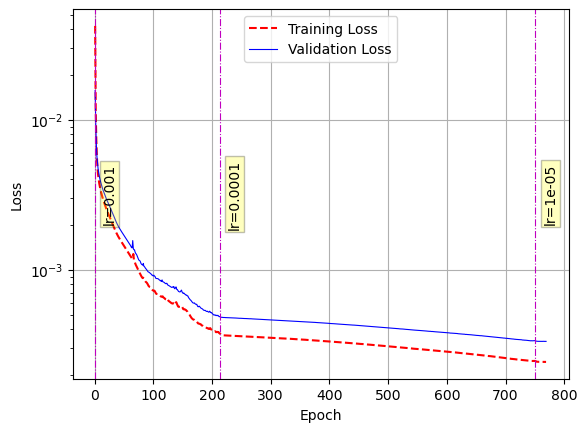

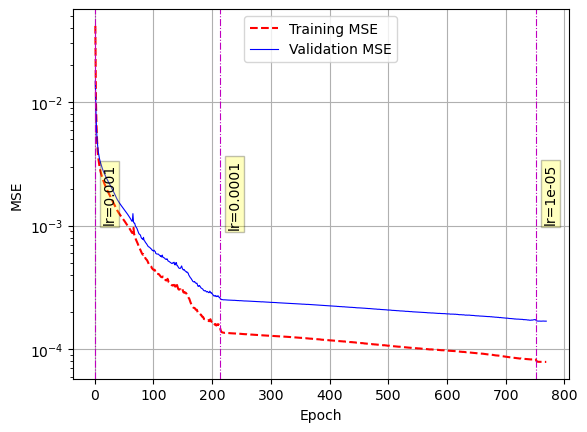

<Figure size 640x480 with 0 Axes>

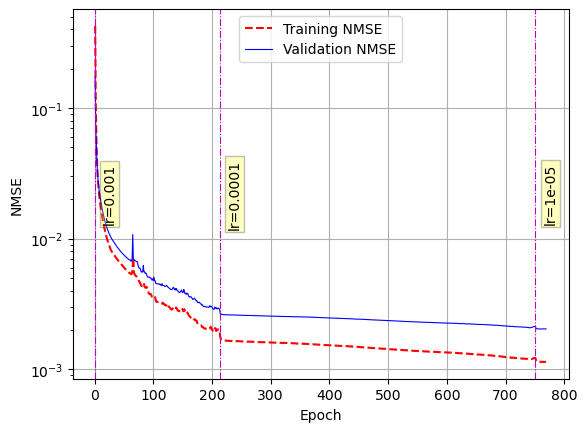

<Figure size 640x480 with 0 Axes>

In [38]:
# plotting losses
dir_name_plot = dir_name_rnn+dir_sep+'plots'
if not os.path.isdir(dir_name_plot):
    os.makedirs(dir_name_plot)

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

plt.savefig(dir_name_rnn+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


fig, ax = plot_losses(
    training_loss=train_MSE_hist,
    val_loss=val_MSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training MSE', 'Validation MSE'],
    xlabel='Epoch',
    ylabel='MSE',
)
plt.savefig(dir_name_plot+'/MSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()


fig, ax = plot_losses(
    training_loss=train_NMSE_hist,
    val_loss=val_NMSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training NMSE', 'Validation NMSE'],
    xlabel='Epoch',
    ylabel='NMSE',
)
plt.savefig(dir_name_plot+'/NMSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()


data_idx : 26


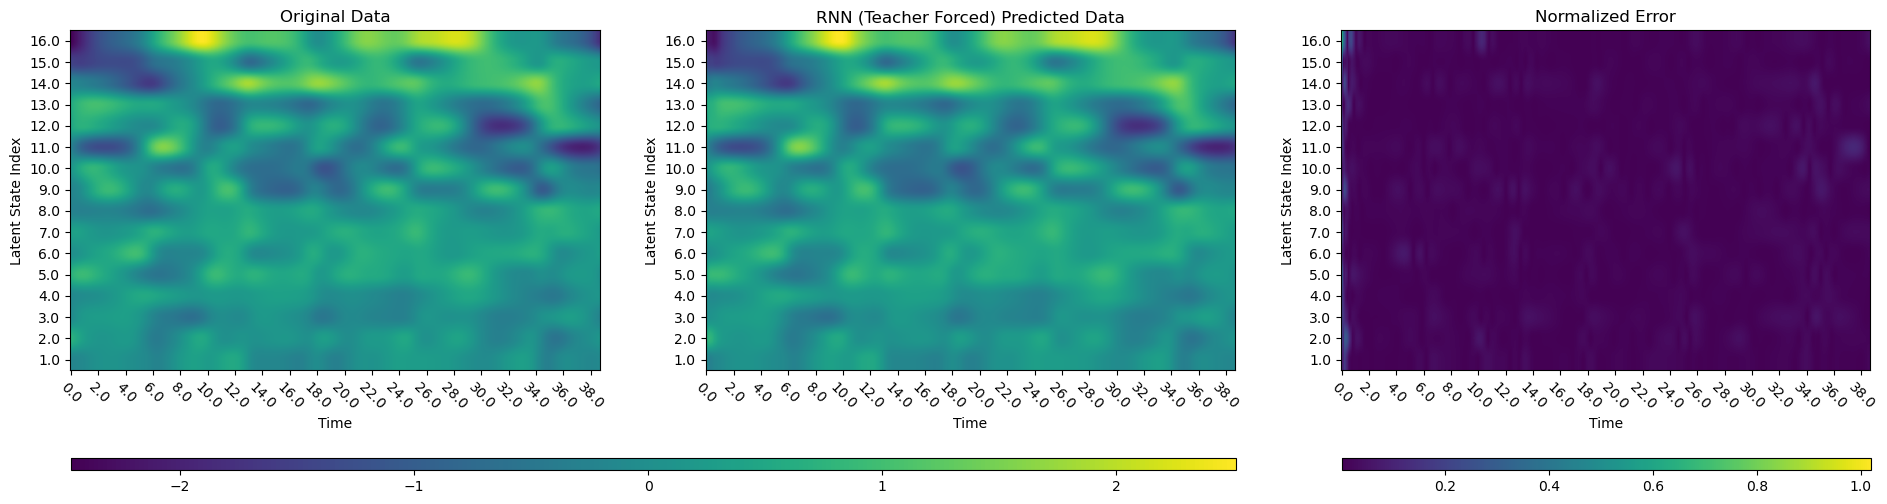

In [40]:
# data_type = 'training'
rnn_net.reset_states()
data_type = 'testing'

data_in = eval(data_type+'_data_rnn_input')
data_out = eval(data_type+'_data_rnn_output')

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 3788
print('data_idx : {}'.format(data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])

plot_reconstructed_data_KS(
    [data_out.shape[0]],
    dir_name_pod,
    data_out,
    prediction[0], delta_t, 1+np.arange(0, data_out.shape[1]),
    save_figs=False,
    normalization_constant_arr=normalization_arr,
    xticks_snapto=2,
    num_yticks=data_out.shape[1],
    ylabel=r'Latent State Index',
    ax1_title=r'Original Data',
    ax2_title=r'RNN (Teacher Forced) Predicted Data')

In [41]:
prediction.shape, data_out.shape, rnn_net.stateful

((64, 387, 16), (387, 16), True)

In [42]:
def rescale_data(data, normalization_arr):
    '''
    data - [num_batches x num_timesteps x num_states]
    normalization_arr = [2 x num_states]
    '''
    new_data = data.copy()
    shape = new_data.shape
    for i in range(data.shape[-1]):
        new_data[:, i] -= normalization_arr[0, i]
        new_data[:, i] /= normalization_arr[1, i]

    return new_data

def norm_sq_time_average(data):
    data_norm_sq = np.zeros(shape=data.shape[0])
    for i in range(data.shape[1]):
        data_norm_sq[:] += data[:, i]**2
    # integrating using the trapezoidal rule
    norm_sq_time_avg = np.sum(data_norm_sq) - 0.5*(data_norm_sq[0]+data_norm_sq[-1])
    norm_sq_time_avg /= data_norm_sq.shape[0]
    return norm_sq_time_avg

def invert_normalization(data, normalization_arr):
    new_data = np.empty_like(data)
    shape = new_data.shape
    print(shape)
    for i in range(shape[-1]):
        if len(shape) == 2:
            new_data[:, i] = data[:, i]
            new_data[:, i] *= normalization_arr[1, i]
            new_data[:, i] += normalization_arr[0, i]
        elif len(shape) == 3:
            new_data[:, :, i] = data[:, :, i]
            new_data[:, :, i] *= normalization_arr[1, i]
            new_data[:, :, i] += normalization_arr[0, i]
    return new_data

case 1, data_idx : 27


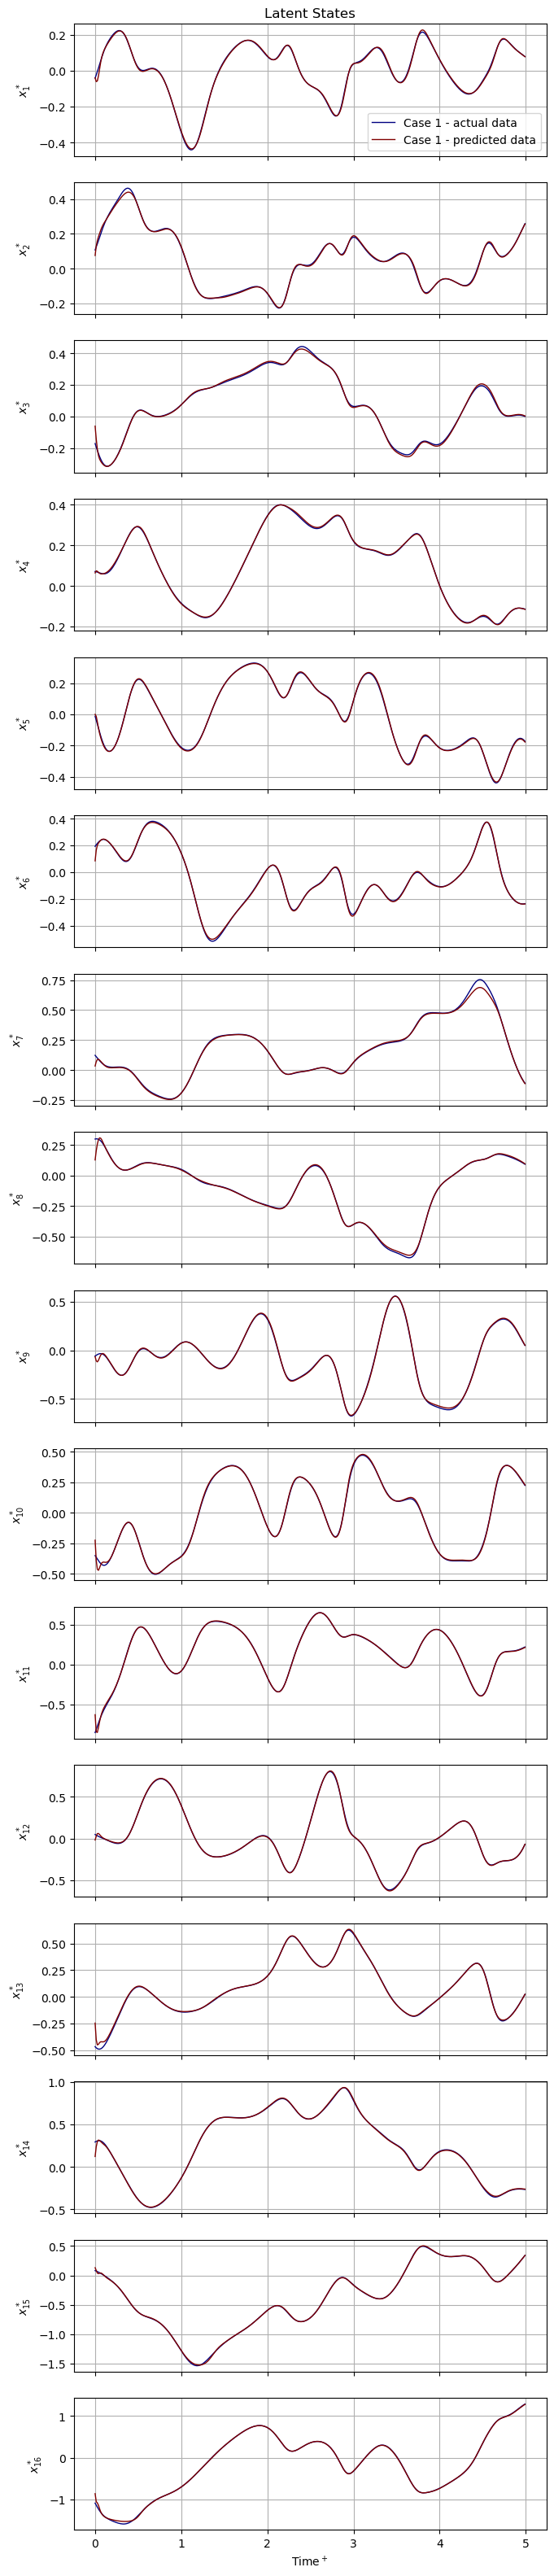


4.991497332033017


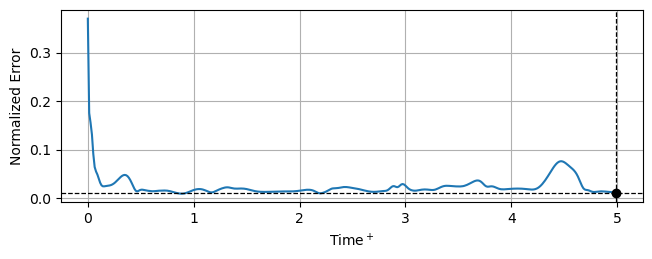

In [43]:
if rnn_net.stateful == True:
    for rnn_layer in rnn_net.rnn_list:
        rnn_layer.reset_states()


data_in = testing_data_rnn_input
data_out = testing_data_rnn_output

data_idx = np.arange(data_in.shape[0])
np.random.shuffle(data_idx)
data_idx = data_idx[0]
# data_idx = 11269
for i in range(len(rnn_data_boundary_idx_arr)):
    if data_idx < rnn_data_boundary_idx_arr[i]:
        case_idx = i
        break
lyap_time = lyapunov_time_arr[case_idx]

print('case {}, data_idx : {}'.format(case_idx+1, data_idx))

# data_in = data_in[data_idx]
data_out = data_out[data_idx]
# data_out = rescale_data(data_out, normalization_arr)
# data_out = invert_normalization(data_out, normalization_arr)

prediction = rnn_net.predict(data_in[data_idx:data_idx+1, :, :])
# prediction = rnn_net(data_in[data_idx:data_idx+1, :, :], training=False)
# prediction = rnn_net.call(data_in[data_idx:data_idx+1, :, :], training=False)
# prediction = invert_normalization(prediction, normalization_arr)

n = 1
num_latent_states = data_out.shape[-1]
N = data_out.shape[0]

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = ['$x^*_{' +str(i)+'}$' for i in range(1, num_latent_states+1)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]
input_time = np.arange(0, N)*dt_rnn/lyap_time

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

mpl_ax_artist_list = []
for j in range(num_latent_states):
    for i in range(n):
        obj_in = ax[j].plot(input_time, data_out[:, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        obj_out = ax[j].plot(input_time, prediction[0, :, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
        mpl_ax_artist_list.append(obj_in[0])
        mpl_ax_artist_list.append(obj_out[0])
    ax[j].set_ylabel(ax_ylabels[j])
    # if xlim is not None:
    #     ax[j].set_xlim(xlim)
    # if ylim is not None:
    #     ax[j].set_ylim(ylim)
    ax[j].grid(True)
    ax[j].set_axisbelow(True)


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)
plt.show()
# plt.savefig('AR-GRU.png', dpi=300, bbox_inches='tight')
print('')

### Error and prediction horizon
# error = np.linalg.norm(data_out[:, :] - prediction[0, :, :], axis=1)
error = (data_out[:, :] - prediction[0, :, :])**2
# error /= norm_sq_time_average(data_out)**0.5
error = np.mean(np.divide(error, time_stddev**2), axis=1)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.5

predhor_idx = np.where(error >= error_threshold)[0]
if predhor_idx.shape[0] == 0:
    predhor_idx = error.shape[0]-1
else:
    predhor_idx = predhor_idx[0]
ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)

plt.show()

In [44]:
normalization_arr

array([[ 5.1373233e-10,  2.8561142e-09, -3.3050611e-09,  4.4039434e-09,
         9.9670752e-09,  7.1452209e-09, -8.8718055e-09, -3.1270400e-09,
         5.7327916e-09,  3.2085878e-09,  1.7796817e-09, -2.4274833e-09,
        -2.1122475e-09, -3.7533323e-09,  2.1402347e-09,  8.2981533e-09],
       [ 1.8041281e+00,  1.8041281e+00,  1.8041281e+00,  1.8041281e+00,
         1.8041281e+00,  1.8041281e+00,  1.8041281e+00,  1.8041281e+00,
         1.8041281e+00,  1.8041281e+00,  1.8041281e+00,  1.8041281e+00,
         1.8041281e+00,  1.8041281e+00,  1.8041281e+00,  1.8041281e+00]],
      dtype=float32)

# Autoregressive Mode

In [45]:
# s_in = testing_data_rnn_input.shape
# testing_data_rnn_input = testing_data_rnn_input.reshape((1, s_in[0]*s_in[1]) + s_in[2:])
# # testing_data_rnn_input = testing_data_rnn_input.reshape((s_in[0], s_in[1]) + s_in[2:])

# s_out = testing_data_rnn_output.shape
# testing_data_rnn_output = testing_data_rnn_output.reshape((1, s_out[0]*s_out[1]) + s_out[2:])
# # testing_data_rnn_output = testing_data_rnn_output.reshape((s_out[0], s_out[1]) + s_out[2:])

In [46]:
temp1 = np.empty_like(testing_data_rnn_input)
temp2 = np.empty_like(testing_data_rnn_output)

begin_idx = 0
testing_data_rolling_count = 0
for i in range(len(rnn_data_boundary_idx_arr)):
    idx = np.arange(begin_idx, rnn_data_boundary_idx_arr[i])
    # np.random.shuffle(idx)
    # num_samples = idx.shape[0]
    # num_train = int( (1-test_split-val_split)*num_samples )
    # num_val = int(val_split*num_samples)
    num_samples = num_samples_arr[i]
    num_test = num_test_arr[i]

    nbatches_test = num_test // batch_size

    for j in range(batch_size):
        temp1[testing_data_rolling_count + j*nbatches_test:testing_data_rolling_count + (j+1)*nbatches_test] = testing_data_rnn_input[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size]
        temp2[testing_data_rolling_count + j*nbatches_test:testing_data_rolling_count + (j+1)*nbatches_test] = testing_data_rnn_output[testing_data_rolling_count+j:testing_data_rolling_count+num_test:batch_size]

    testing_data_rolling_count += num_test

    begin_idx = rnn_data_boundary_idx_arr[i]

In [47]:
testing_data_rnn_input_og = testing_data_rnn_input
testing_data_rnn_output_og = testing_data_rnn_output

testing_data_rnn_input = temp1
testing_data_rnn_output = temp2

In [48]:
s_in = testing_data_rnn_input.shape
testing_data_rnn_input = testing_data_rnn_input.reshape((1, s_in[0]*s_in[1]) + s_in[2:])
# testing_data_rnn_input = testing_data_rnn_input.reshape((s_in[0], s_in[1]) + s_in[2:])

s_out = testing_data_rnn_output.shape
testing_data_rnn_output = testing_data_rnn_output.reshape((1, s_out[0]*s_out[1]) + s_out[2:])
# testing_data_rnn_output = testing_data_rnn_output.reshape((s_out[0], s_out[1]) + s_out[2:])

In [49]:
T_sample_input_AR = 1*np.mean(lyapunov_time_arr)#50.1*dt_rnn
num_sample_input_AR = int((T_sample_input_AR+0.5*dt_rnn)//dt_rnn)

T_sample_output_AR = 10*np.mean(lyapunov_time_arr)
num_sample_output_AR = int((T_sample_output_AR+0.5*dt_rnn)//dt_rnn)

num_offset_AR = num_sample_input_AR
T_offset_AR = num_offset_AR*dt_rnn

batch_idx : 0
data_idx : 5530
data_.shape : (1, 850, 16)


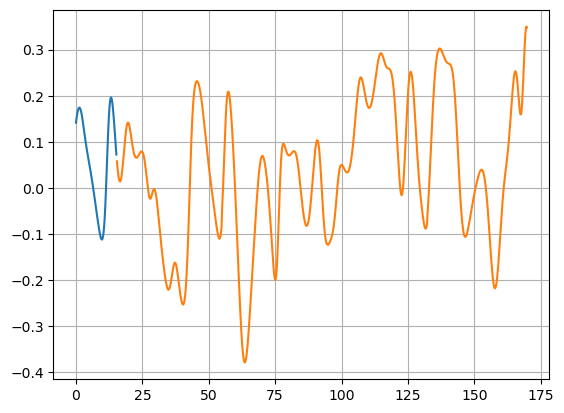

In [79]:
# data_to_consider = 'training'
data_to_consider = 'testing'

data_in = eval(data_to_consider+'_data_rnn_input')
data_out = eval(data_to_consider+'_data_rnn_output')

batch_idx = np.random.randint(low=0, high=data_in.shape[0])
maxpossible_num_runs = data_in.shape[1]-(num_sample_input_AR+num_sample_output_AR)

data_idx = np.random.randint(low=0, high=maxpossible_num_runs)

print('batch_idx : {}'.format(batch_idx))
print('data_idx : {}'.format(data_idx))
data_ = data_in[batch_idx:batch_idx+1, data_idx:data_idx+(num_sample_input_AR+num_sample_output_AR), :]
print('data_.shape :', data_.shape)

plt.plot(dt_rnn*np.arange(num_sample_input_AR), data_[0, 0:num_sample_input_AR, 0])
plt.plot(dt_rnn*num_sample_input_AR+dt_rnn*np.arange(num_sample_output_AR), data_[0, num_sample_input_AR:, 0])
plt.grid(True)
plt.show()

In [80]:
prediction_lst = []

for layer in rnn_net.rnn_list:
    if layer.stateful == True:
        layer.reset_states()

    if data_.shape[0] != batch_size:
        data_ = np.tile(data_, (batch_size, 1, 1))
input_preds = np.array(rnn_net(data_[:, 0:num_sample_input_AR, :], training=False))

prediction_lst.append(input_preds[:, -2:-1, :])

for i in range(1, num_sample_output_AR):
    data_in_i = np.array(prediction_lst[-1])
    output = np.array(rnn_net(data_in_i, training=False))
    prediction_lst.append(output[:, 0:1, :])

In [81]:
prediction_lst = np.stack(prediction_lst)
prediction_lst = np.squeeze(prediction_lst)
if rnn_net.stateful == True:
    prediction_lst = np.transpose(prediction_lst, [1, 0, 2])
# print(np.squeeze(prediction_lst).shape)
# print(np.transpose(prediction_lst, [1, 0, 2]).shape)

print('input_preds.shape : {}'.format(input_preds.shape))
print('prediction_lst.shape : {}'.format(prediction_lst.shape))
print('normalization_arr[0, :] : {}'.format(normalization_arr[0, :]))
print('normalization_arr[1, :] : {}'.format(normalization_arr[1, :]))

input_preds.shape : (64, 77, 16)
prediction_lst.shape : (64, 773, 16)
normalization_arr[0, :] : [ 5.1373233e-10  2.8561142e-09 -3.3050611e-09  4.4039434e-09
  9.9670752e-09  7.1452209e-09 -8.8718055e-09 -3.1270400e-09
  5.7327916e-09  3.2085878e-09  1.7796817e-09 -2.4274833e-09
 -2.1122475e-09 -3.7533323e-09  2.1402347e-09  8.2981533e-09]
normalization_arr[1, :] : [1.804128 1.804128 1.804128 1.804128 1.804128 1.804128 1.804128 1.804128
 1.804128 1.804128 1.804128 1.804128 1.804128 1.804128 1.804128 1.804128]


In [82]:
data_ = data_[0:1]
if rnn_net.stateful == True:
    prediction_lst = prediction_lst[0]
input_preds = input_preds[0]

In [83]:
print('time_stddev : {}'.format(time_stddev))

time_stddev : [0.14721279 0.14788986 0.21613372 0.21822045 0.21887236 0.22007856
 0.22577254 0.22951699 0.31044289 0.31380079 0.43229446 0.43716323
 0.47733563 0.47920379 0.62696274 0.63243267]


0.4008715473912527


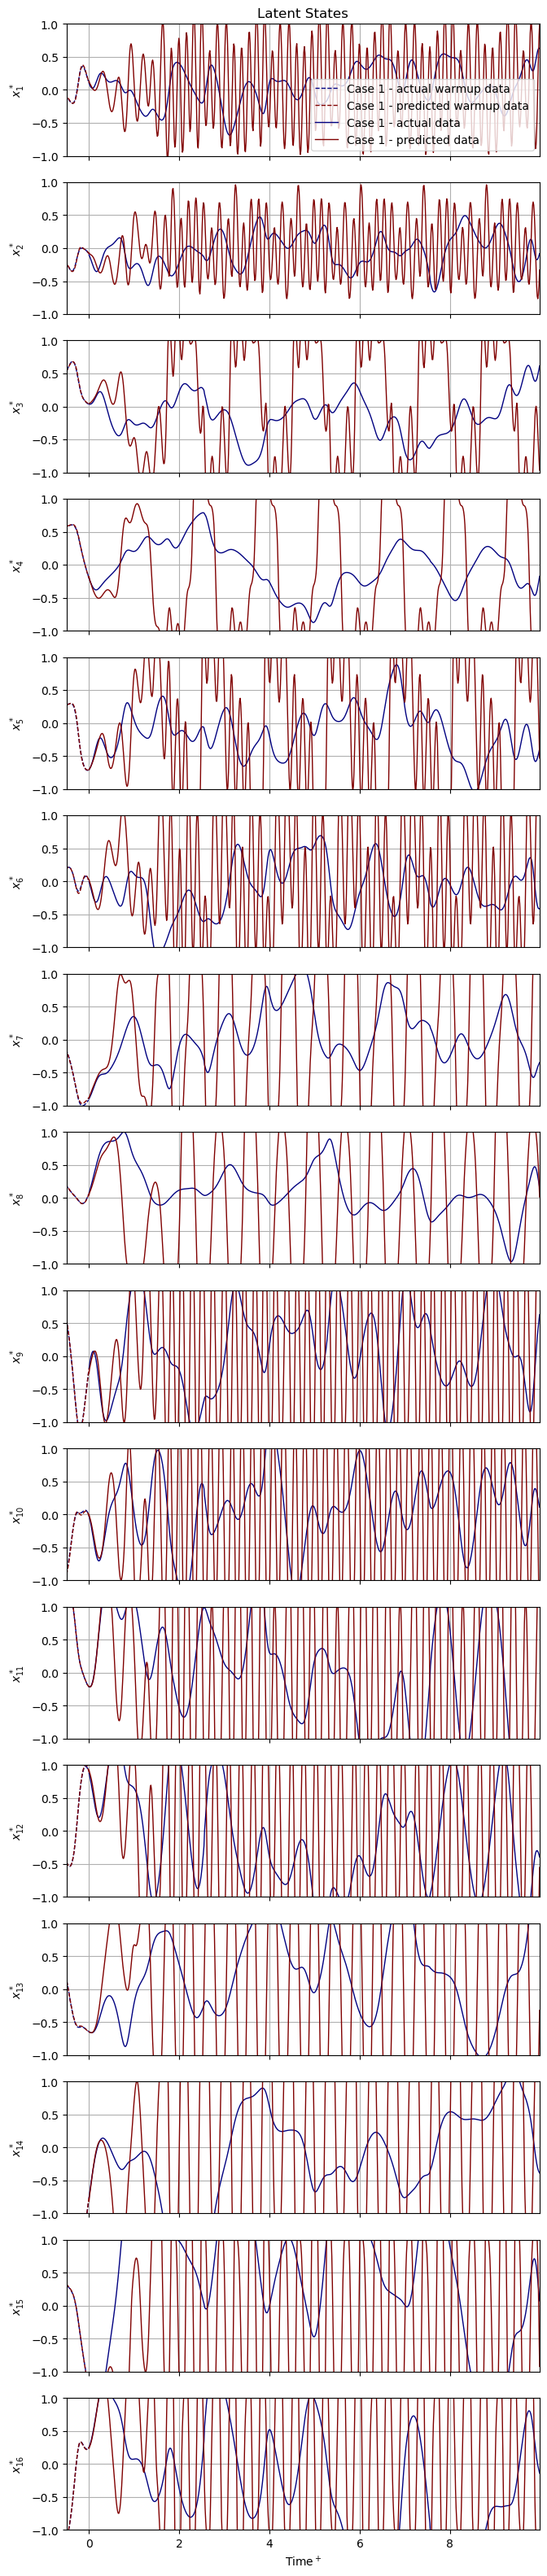

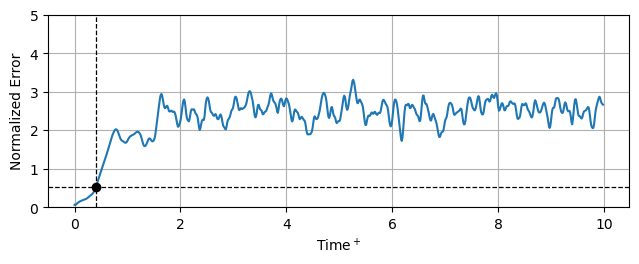

In [84]:
lyap_time = np.mean(lyapunov_time_arr)

data_plot = data_*normalization_arr[1, :] + normalization_arr[0, :]
input_preds_plot = input_preds*normalization_arr[1, :] + normalization_arr[0, :]
prediction_lst_plot = prediction_lst*normalization_arr[1, :] + normalization_arr[0, :]

n = 1
num_latent_states = input_preds.shape[-1]
N = num_sample_output_AR#num_output_timesteps

num_cols = 1
num_rows = n*num_latent_states

ax_ylabels = [r'$x^*_{'+str(i+1)+'}$' for i in range(num_latent_states)]

fig, ax = plt.subplots(num_latent_states, 1, sharex=True, figsize=(7.5*num_cols, 2.5*num_rows))
if num_latent_states == 1:
    ax = [ax]

cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, 2*n)]

prev_idx = 0

time_arr_warmup1 = (np.arange(num_sample_input_AR) - num_sample_input_AR)*dt_rnn
time_arr_warmup2 = time_arr_warmup1 + dt_rnn

time_arr_warmup1 /= lyap_time
time_arr_warmup2 /= lyap_time

input_time = time_arr_warmup2[-1]+np.arange(N, dtype=float)*dt_rnn/lyap_time

for j in range(num_latent_states):
    for i in range(n):
        ax[j].plot(time_arr_warmup1, data_plot[0, 0:num_sample_input_AR, j], linestyle='--', linewidth=1, color=colors[2*i], label='Case {} - actual warmup data'.format(i+1))
        ax[j].plot(time_arr_warmup2, input_preds_plot[:, j], linestyle='--', linewidth=1, color=colors[2*i+1], label='Case {} - predicted warmup data'.format(i+1))
        ax[j].plot(input_time, data_plot[0, num_sample_input_AR:num_sample_input_AR+N, j], linewidth=1, color=colors[2*i], label='Case {} - actual data'.format(i+1))
        ax[j].plot(input_time, prediction_lst_plot[:, j], linewidth=1, color=colors[2*i+1], label='Case {} - predicted data'.format(i+1))
    ax[j].set_ylabel(ax_ylabels[j])
    ax[j].grid(True)
    ax[j].set_axisbelow(True)
    ax[j].set_ylim([-1, 1])
    ax[j].set_xlim([input_time[0] - 0.5, input_time[-1]])


ax[-1].set_xlabel('Time$^+$')

max_rows = 10
max_rows = float(max_rows)
ncols = int(np.ceil(len(boundary_idx_arr) / max_rows))
ax[0].legend(
    loc='best',
    ncol=ncols,
)
ax[0].set_title(r'Latent States', size=12)


### error computation
error = (data_[0, num_sample_input_AR:num_sample_input_AR+N, :] - prediction_lst[:, :])**2
# error /= norm_sq_time_average(data_out)**0.5
error = np.mean(np.divide(error, time_stddev**2), axis=1)**0.5

# print(norm_sq_time_average(data_out)**0.5)

fig2, ax2 = plt.subplots(1, 1, figsize=(7.5, 2.5))
ax2.plot(input_time, error)
ax2.grid(True)
ax2.set_axisbelow(True)
ax2.set_xlabel('Time$^+$')
ax2.set_ylabel('Normalized Error')

error_threshold = 0.5

predhor_idx = np.where(error >= error_threshold)[0]
if predhor_idx.shape[0] == 0:
    predhor_idx = error.shape[0]-1
else:
    predhor_idx = predhor_idx[0]
ax2.plot(input_time[predhor_idx], error[predhor_idx], 'o', color='k')
ax2.axhline(error[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.axvline(input_time[predhor_idx], linewidth=0.9, linestyle='--', color='k')
ax2.set_ylim([0, 5])

prediction_horizon = predhor_idx*dt_rnn/lyap_time
print(prediction_horizon)

In [85]:
# sp = np.array([var.numpy() for var in rnn_net.scalar_multiplier_pre_list])
# print(sp)
# sum_ = np.sum(np.exp(sp))
# print(np.exp(sp)/sum_)

In [86]:
rnn_net.dense[-1].weights

[<tf.Variable 'rnn_gru/time_distributed_1/individual_weights:0' shape=(16,) dtype=float32, numpy=
 array([1.2926013 , 0.73922676, 0.94936913, 1.0036857 , 1.2913468 ,
        1.1526216 , 1.1228701 , 1.3522664 , 1.5716658 , 1.2444638 ,
        1.5634912 , 1.4906979 , 1.3872703 , 1.3912821 , 1.6324129 ,
        1.5648134 ], dtype=float32)>]

In [87]:
if 'use_trainable_weights_with_reslayers' in rnn_net.__dict__.keys():
    if use_trainable_weights_with_reslayers == True:
        for i in range(rnn_net.num_skip_connections):
            print('reslayer_factor_{} : {}'.format(i, rnn_net.reslayer_factor[i]))

reslayer_factor_0 : <tf.Variable 'reslayer_weight_0:0' shape=() dtype=float32, numpy=0.9888045>
reslayer_factor_1 : <tf.Variable 'reslayer_weight_1:0' shape=() dtype=float32, numpy=0.99815106>
